# Modules

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time as t
import pandas as pd 
import numba
import antropy as ant
import scipy
from numpy.fft import rfft, rfftfreq
from scipy.signal import argrelmax, stft, welch
from statsmodels.tsa.stattools import acf, adfuller
from itertools import tee
import arff as ar
import EntropyHub as EH

# ApEn et SampEn





## Implémentations personnelles

In [6]:
def apen(series, m, r):
    """
    Approximate Entropy (ApEn).
    Entrées:
        series : array-like, série temporelle
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de l'ApEn
    """
    series = (series - np.mean(series)) / np.std(series)
    def _phi(m):
        N = len(series)
        phi = 0
        count = 0
        for i in range(N - m + 1):
            for j in range(N - m + 1):
                if np.max(np.abs(series[i:i+m] - series[j:j+m])) <= r:
                    count += 1
            if count == 0 : 
                return(-np.inf)
            phi += np.log(count/(N - m + 1))
            count = 0
        return phi / (N - m + 1)

    return _phi(m) - _phi(m + 1)

def apen_unbiaised(series,m,r):
    series = (series - np.mean(series)) / np.std(series)
    def _phi(m):
        N = len(series)
        phi = 0
        count = -1
        for i in range(N - m + 1):
            for j in range(N - m + 1):
                if np.max(np.abs(series[i:i+m] - series[j:j+m])) <= r:
                    count += 1
            if count == 0 : 
                return(-np.inf)
            phi += np.log(count/(N - m + 1))
            count = -1
        return phi / (N - m + 1)

    return _phi(m) - _phi(m + 1)

def sampen(series, m, r):
    """
    Sample Entropy (SampEn).
    Entrées:
        series : array-like, série temporelle
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de la SampEn
    """
    series = (series - np.mean(series)) / np.std(series)
    def _count(m):
        N = len(series)
        count = 0
        for i in range(N - m):
            for j in range(i + 1, N - m):
                if np.max(np.abs(series[i:i+m] - series[j:j+m])) <= r:
                    count += 1
        return count

    A = _count(m + 1)
    B = _count(m)
    if B == 0 :
        return -np.inf  # Éviter les divisions par zéro
    return -np.log(A / B)




## Implémentations personnelles optimisées 

On utilise la bibliothèque Numba pour traduire les codes précédents dans un langage plus adapté à la machine. 

In [7]:
@numba.njit()
def approx_entropy(series, m, r):
    """
    Approximate Entropy (ApEn).
    Entrées:
        series : array-like, série temporelle
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de l'ApEn
    """
    series = (series - np.mean(series)) / np.std(series)
    def _phi(m):
        N = len(series)
        phi = 0.0
        count = 0
        for i in range(N - m + 1):
            for j in range(N - m + 1):
                if np.max(np.abs(series[i:i+m] - series[j:j+m])) <= r:
                    count += 1
            if count == 0:
                return -np.inf
            phi += np.log(count / (N - m + 1))
            count = 0
        return phi / (N - m + 1)

    return _phi(m) - _phi(m + 1)


@numba.njit()
def approx_entropy_unbiased(series, m, r):
    """
    Approximate Entropy sans auto-correspondances (unbiased).
    """
    series = (series - np.mean(series)) / np.std(series)
    def _phi(m):
        N = len(series)
        phi = 0.0
        count = -1
        for i in range(N - m + 1):
            for j in range(N - m + 1):
                if np.max(np.abs(series[i:i+m] - series[j:j+m])) <= r:
                    count += 1
            if count == 0:
                return -np.inf
            phi += np.log(count / (N - m + 1))
            count = -1
        return phi / (N - m + 1)

    return _phi(m) - _phi(m + 1)


@numba.njit()
def sample_entropy(series, m, r):
    """
    Sample Entropy (SampEn).
    Entrées:
        series : array-like, série temporelle
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de la SampEn
    """
    series = (series - np.mean(series)) / np.std(series)
    def _count(m):
        N = len(series)
        count = 0
        for i in range(N - m):
            for j in range(i + 1, N - m):
                if np.max(np.abs(series[i:i+m] - series[j:j+m])) <= r:
                    count += 1
        return count

    A = _count(m + 1)
    B = _count(m)
    if B == 0:
        return -np.inf
    return -np.log(A / B)


## Implémentations avec AntroPy 

In [8]:
def approx_entropy_antropy(series, m, r):
    """
    Approximate Entropy (ApEn) en utilisant la bibliothèque antropy.
    La tolérance r est intégrée via une normalisation de la série temporelle.

    Entrées:
        series : array-like, série temporelle
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de l'ApEn
    """
    # Normalisation de la série par la tolérance r
    series = (series - np.mean(series)) / np.std(series)
    return ant.app_entropy(series, order=m, metric='chebyshev')

def sample_entropy_antropy(series, m, r):
    """
    Sample Entropy (SampEn) en utilisant la bibliothèque antropy.
    La tolérance r est intégrée via une normalisation de la série temporelle.

    Entrées:
        series : array-like, série temporelle
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de la SampEn
    """
    # Normalisation de la série par la tolérance r
    series =  (series - np.mean(series)) / np.std(series)
    return ant.sample_entropy(series, order=m)

# Cross-ApEn et Cross-SampEn

## Implémentations personnelles 

In [9]:
def cross_apen(series_u, series_v, m, r):
    """
    Cross Approximate Entropy (Cross-ApEn).
    Entrées:
        series_u, series_v : array-like, séries temporelles
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de la Cross-ApEn
    """
    series_u = (series_u - np.mean(series_u)) / np.std(series_u)
    series_v = (series_v - np.mean(series_v)) / np.std(series_v)
    def _phi(m):
        N = len(series_u)
        count = 0
        phi = 0
        for i in range(N - m + 1):
            for j in range(N - m + 1):
                if np.max(np.abs(series_u[i:i+m] - series_v[j:j+m])) <= r:
                    count += 1
            if count == 0 : 
                return(-np.inf)
            phi += np.log(count/(N - m + 1))
            count = 0
        return phi / (N - m + 1)
    return _phi(m) - _phi(m + 1)



def cross_apen_biais_max(series_u, series_v, m, r):
    """
    Cross Approximate Entropy (Cross-ApEn) avec biais-max.
    """
    # Normalisation des séries
    series_u = (series_u - np.mean(series_u)) / np.std(series_u)
    series_v = (series_v - np.mean(series_v)) / np.std(series_v)

    def _phi(m):
        N = len(series_u)
        phi = 0
        for i in range(N - m + 1):
            count = 0
            for j in range(N - m + 1):
                if np.max(np.abs(series_u[i:i+m] - series_v[j:j+m])) <= r:
                    count += 1
            # Correction biais-max : Si count == 0, on met count = 1 / (N - m + 1)
            if count == 0:
                count = 1 / (N - m + 1)
            phi += np.log(count / (N - m + 1))
        return phi / (N - m + 1)

    return _phi(m) - _phi(m + 1)


def cross_apen_biais_0(series_u, series_v, m, r):
    """
    Cross Approximate Entropy (Cross-ApEn) avec biais-min.
    """
    # Normalisation des séries
    series_u = (series_u - np.mean(series_u)) / np.std(series_u)
    series_v = (series_v - np.mean(series_v)) / np.std(series_v)

    def _phi(m):
        N = len(series_u)
        phi = 0
        for i in range(N - m + 1):
            count = 0
            for j in range(N - m + 1):
                if np.max(np.abs(series_u[i:i+m] - series_v[j:j+m])) <= r:
                    count += 1
            # Correction biais-min : Si count == 0, on met count = 1
            if count == 0:
                count = 1
            phi += np.log(count / (N - m + 1))
        return phi / (N - m + 1)

    return _phi(m) - _phi(m + 1)

def cross_sampen(series_u, series_v, m, r):
    """
    Cross Sample Entropy (Cross-SampEn).
    Entrées:
        series_u, series_v : array-like, séries temporelles
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de la Cross-SampEn
    """
        
    def _count(m):
        N = len(series_u)
        count = 0
        for i in range(N - m):
            for j in range(N - m):
                if np.max(np.abs(series_u[i:i+m] - series_v[j:j+m])) <= r:
                    count += 1
        return count

    A = _count(m + 1)
    B = _count(m)
    if B == 0:
        return np.inf  # Éviter les divisions par zéro
    return -np.log(A / B)

## Implémentations optimisées 

In [10]:
import numpy as np
import numba

@numba.njit()
def cross_apen_opt(series_u, series_v, m, r):
    """
    Cross Approximate Entropy (Cross-ApEn).
    Entrées:
        series_u, series_v : array-like, séries temporelles
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de la Cross-ApEn
    """
    series_u = (series_u - np.mean(series_u)) / np.std(series_u)
    series_v = (series_v - np.mean(series_v)) / np.std(series_v)
    def _phi(m):
        N = len(series_u)
        phi = 0.0
        for i in range(N - m + 1):
            count = 0
            for j in range(N - m + 1):
                if np.max(np.abs(series_u[i:i+m] - series_v[j:j+m])) <= r:
                    count += 1
            if count == 0:
                return -np.inf  # Éviter les problèmes logarithmiques
            phi += np.log(count / (N - m + 1))
        return phi / (N - m + 1)
    return _phi(m) - _phi(m + 1)

@numba.njit()
def cross_apen_biais_max_opt(series_u, series_v, m, r):
    """
    Cross Approximate Entropy (Cross-ApEn) avec biais-max.
    """
    # Normalisation des séries
    series_u = (series_u - np.mean(series_u)) / np.std(series_u)
    series_v = (series_v - np.mean(series_v)) / np.std(series_v)

    def _phi(m):
        N = len(series_u)
        phi = 0
        for i in range(N - m + 1):
            count = 0
            for j in range(N - m + 1):
                if np.max(np.abs(series_u[i:i+m] - series_v[j:j+m])) <= r:
                    count += 1
            # Correction biais-max : Si count == 0, on met count = 1 / (N - m + 1)
            if count == 0:
                count = 1 
            phi += np.log(count / (N - m + 1))
        return phi / (N - m + 1)

    return _phi(m) - _phi(m + 1)

@numba.njit()
def cross_apen_biais_0_opt(series_u, series_v, m, r):
    """
    Cross Approximate Entropy (Cross-ApEn) avec biais-min.
    """
    # Normalisation des séries
    series_u = (series_u - np.mean(series_u)) / np.std(series_u)
    series_v = (series_v - np.mean(series_v)) / np.std(series_v)

    def _phi(m):
        N = len(series_u)
        phi = 0
        for i in range(N - m + 1):
            count = 0
            for j in range(N - m + 1):
                if np.max(np.abs(series_u[i:i+m] - series_v[j:j+m])) <= r:
                    count += 1
            # Correction biais-min : Si count == 0, on met count = 1
            if count == 0:
                count = N-m+1
            phi += np.log(count / (N - m + 1))
        return phi / (N - m + 1)

    return _phi(m) - _phi(m + 1)
@numba.njit()
def cross_sampen_opt(series_u, series_v, m, r):
    """
    Cross Sample Entropy (Cross-SampEn).
    Entrées:
        series_u, series_v : array-like, séries temporelles
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de la Cross-SampEn
    """
    series_u = (series_u - np.mean(series_u)) / np.std(series_u)
    series_v = (series_v - np.mean(series_v)) / np.std(series_v)
    def _count(m):
        N = len(series_u)
        count = 0
        for i in range(N - m):
            for j in range(N - m):
                if np.max(np.abs(series_u[i:i+m] - series_v[j:j+m])) <= r:
                    count += 1
        return count

    A = _count(m + 1)
    B = _count(m)
    if B == 0:
        return np.inf  # Éviter les divisions par zéro
    return -np.log(A / B)


## Implémentations avec EntropyHub

In [11]:
import numpy as np
import antropy as ant

def cross_approx_entropy_EH(series_u, series_v, m, r):
    """
    Cross Approximate Entropy (Cross-ApEn) en utilisant la bibliothèque antropy.
    La tolérance r est intégrée via une normalisation des séries temporelles.

    Entrées:
        series_u, series_v : array-like, séries temporelles
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de la Cross-ApEn
    """
    # Normalisation des deux séries temporelles
    series_u = (series_u - np.mean(series_u)) / np.std(series_u)
    series_v = (series_v - np.mean(series_v)) / np.std(series_v)
    XAp, Phi = EH.XApEn(series_u , series_v, m=m, r=r)
    print(EH.XApEn(series_u , series_v, m=m, r=r))
    # Utilisation de la fonction app_entropy avec metric='chebyshev'
    return (XAp[-1])

def cross_sample_entropy_EH(series_u, series_v, m, r):
    """
    Cross Sample Entropy (Cross-SampEn) en utilisant la bibliothèque antropy.
    La tolérance r est intégrée via une normalisation des séries temporelles.

    Entrées:
        series_u, series_v : array-like, séries temporelles
        m : int, taille des motifs
        r : float, tolérance
    Sortie:
        float, valeur de la Cross-SampEn
    """
    # Normalisation des deux séries temporelles
    series_u = (series_u - np.mean(series_u)) / np.std(series_u)
    series_v = (series_v - np.mean(series_v)) / np.std(series_v)
    XSamp = EH.XSampEn(series_u , series_v, m=m, r=r)[0]
    # Utilisation de la fonction sample_entropy avec metric='chebyshev'
    return (XSamp[-1])


# Data 

**Utility functions**

In [12]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def get_largest_local_max(signal1D: np.ndarray, order: int = 1):
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_index = all_local_max_indexes[all_local_max.argsort()[-1]]

    return signal1D[largest_local_max_index], largest_local_max_index

def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

def normalize_signal(signal):
    """Normalizes a signal to have a standard deviation of 1.

    Args:
        signal (np.array): Input signal.

    Returns:
        np.array: Normalized signal.
    """
    mean = np.mean(signal)
    std = np.std(signal)
    if std == 0:
        raise ValueError("Standard deviation is zero. Normalization not possible.")
    return (signal - mean) / std

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

**Analysis functions**

In [13]:
def tracer_signal(signal, fs):
    """Plot the signal and the tracer signal.

    Args:
        X (np.array): shape (n_samples, )
        freq (int): sampling frequency
    """
    n_samples = signal.shape[0]
    fig, ax = fig_ax()
    tt = np.arange(n_samples) / fs
    ax.plot(tt, signal)
    _ = ax.set_xlim(0, n_samples / fs)

def plot_spectrogram(signal, fs, cut_off_freq):
    """plot the spectrogram of the signal for freq < cut_off_freq.

    Args:
        signal (np.array): _description_
        fs (int): _description_
        cut_off_freq (int): _description_
    """
    # Ajuster nperseg pour les signaux courts
    nperseg = min(512, len(signal) // 2)
    noverlap = nperseg // 2
    print(f"nperseg: {nperseg}, noverlap: {noverlap}, signal length: {len(signal)}")
    fig, ax = fig_ax()

    f, t, Zxx = stft(signal, fs,  nperseg=nperseg, noverlap=noverlap)

    keep_mask = f < cut_off_freq

    ax.pcolormesh(
        t, f[keep_mask], np.abs(Zxx[keep_mask]), vmin=0, shading="gouraud"
    )
    ax.set_xlabel("Time (s)")
    _ = ax.set_ylabel("Frequency (Hz)")


def welch_psd(signal, fs, nperseg=256, noverlap=None):
    """
    Compute and plot Welch's Power Spectral Density (PSD) estimate.

    Args:
        signal (np.ndarray): The input time-series signal.
        fs (float): Sampling frequency of the signal in Hz.
        nperseg (int): Length of each segment for FFT computation. Default is 256.
        noverlap (int or None): Number of overlapping samples between segments. Default is None.

    Returns:
        f (np.ndarray): Array of sample frequencies.
        Pxx (np.ndarray): Power Spectral Density of the signal.
    """
    # Calculer la DSP avec la méthode de Welch
    f, Pxx = welch(signal, fs, nperseg=nperseg, noverlap=noverlap)
    
    # Plot la DSP
    plt.figure(figsize=(10, 6))
    plt.semilogy(f, Pxx, label="Welch's PSD")
    plt.title("Welch's Power Spectral Density (PSD)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()
    
    return f, Pxx

def get_distribution_features(signal: np.ndarray) -> dict:
    res_dict = dict()
    res_dict["mean"] = signal.mean()
    res_dict["std"] = signal.std()
    res_dict["min"] = signal.min()
    res_dict["max"] = signal.max()
    res_dict["skew"] = scipy.stats.skew(signal)
    res_dict["kurtosis"] = scipy.stats.kurtosis(signal)
    res_dict['25%'] = np.percentile(signal, 25)
    res_dict['50%'] = np.percentile(signal, 50)
    res_dict['75%'] = np.percentile(signal, 75)
    return res_dict

def plot_autocorr(signal, nlags=500):
    """Plot the autocorrelation of the signal.

    Args:
        signal (np.array): _description_
        fs (np.array): _description_
    """
    fig, ax = fig_ax()
    ax.plot(acf(signal, nlags, fft=True), ".-")
    ax.axhline(0, ls="--", color="k")
    plt.show()

def plot_fft(signal, fs):
    """Plot the Fourier transform of the signal.

    Args:
        signal (np.array): _description_
        fs (int): _description_
    """
    n_samples = signal.shape[0]
    fourier = abs(rfft(signal)) ** 2
    freqs = rfftfreq(n=n_samples, d=1.0 / fs)

    fig, ax = fig_ax()
    ax.plot(freqs, fourier)
    ax.set_xlabel("Frequency (Hz)")
    _ = ax.set_ylabel("Fourier coefficient")

def calculate_snr(signal, window_size=10, mode='same'):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels (dB).
    
    Args:
        signal (np.ndarray): Original signal.
        window_size (int): Window size for smoothing the signal (default: 10).
        mode (str): Mode for convolution, can be 'full', 'valid', or 'same' (default: 'same').
        
    Returns:
        float: SNR in dB.
    """
    # On lisse le signal
    smoothed_signal = np.convolve(signal, np.ones(window_size) / window_size, mode=mode)

    # On estime le bruit comme la différence entre le signal original et le signal lissé
    noise = signal - smoothed_signal[:len(signal)]
    
    # Calcul des puissances du signal et du bruit
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    
    if noise_power == 0:
        return np.inf  
    
    # Conversion décibels
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

### Préparation

In [14]:
# Chemin des données
data_set = 'ECGFiveDays'
TRAIN_TEST = 'TRAIN'
file_path = f"{data_set}/{data_set}_{TRAIN_TEST}.arff"




# Charger les données ARFF
with open(file_path, 'r') as f:
    data= ar.load(f)
data = ar.load("ECGFiveDays/ECGFiveDays_TRAIN.arff")
for row in data : 
    print (row)
data_values = np.array(data['array'])
# Charger les données
# Convertir en tableau NumPy
data_values = np.array(data.tolist())
signals = data_values[:, :-1]  
labels = data_values[:, -1]    
signal_index = 15 # Changer l'index pour visualiser un autre signal
print(f"label : {labels[signal_index]}")
signal = signals[signal_index, :]
signal.shape
signal = signal.astype(np.float64)
normalized_signal = normalize_signal(signal)

FileNotFoundError: [Errno 2] No such file or directory: 'ECGFiveDays/ECGFiveDays_TRAIN.arff'

In [ ]:
signal = signal.astype(np.float64)
normalized_signal = normalize_signal(signal)


In [ ]:
label_1_signals = signals[labels == '1']

# Signal reconstruit
normalized_signals_label_1 = np.concatenate([normalize_signal(signal.astype(np.float64)) for signal in label_1_signals])

normalized_signals_label_1

ValueError: need at least one array to concatenate

### Analyse

In [ ]:
fs = 500
get_distribution_features(normalized_signal)
tracer_signal(normalized_signal, fs)
plot_spectrogram(normalized_signal, fs, cut_off_freq=250)
plot_autocorr(normalized_signal)
plot_fft(normalized_signal, fs)
welch_psd(normalized_signal, fs, nperseg=256, noverlap=None)
adf_test(normalized_signal)
calculate_snr(normalized_signal, window_size=10, mode='same')

## MIX

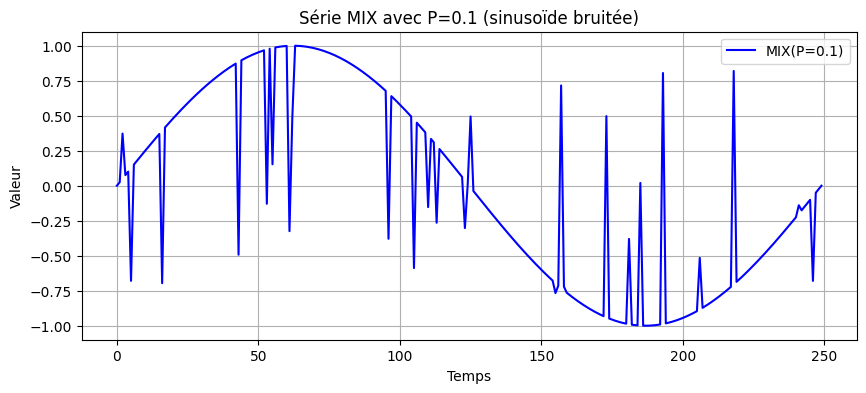

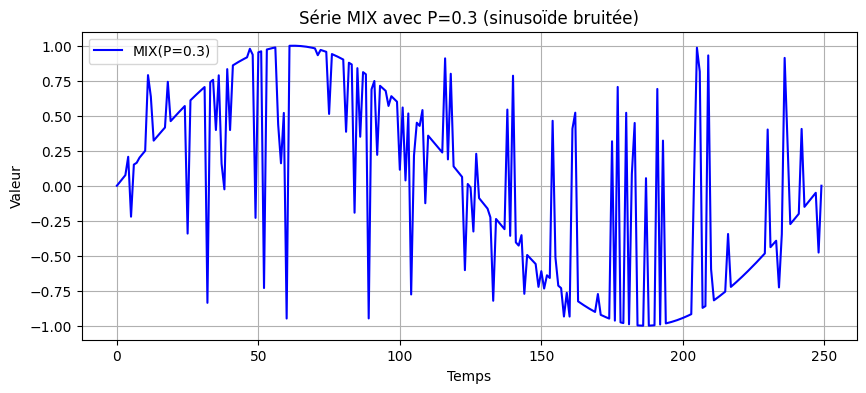

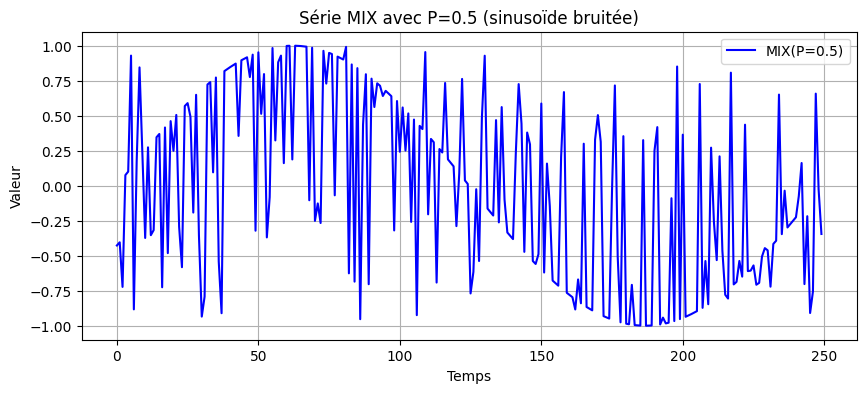

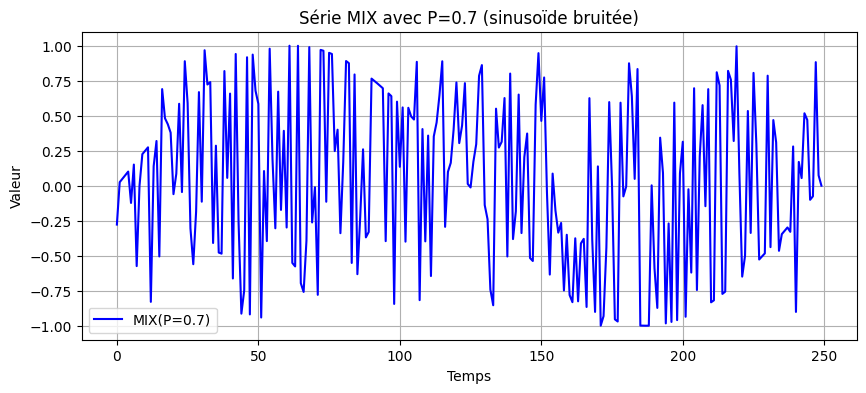

In [15]:

def generate_mix_series(N, P, amplitude=1.0, frequency=1.0, noise_range=(-1, 1)):
    """
    Génère une série MIX(P) : une sinusoïde bruitée avec une proportion P de bruit.
    
    Parameters:
        N (int): Longueur de la série temporelle.
        P (float): Proportion de points remplacés par du bruit (entre 0 et 1).
        amplitude (float): Amplitude de la sinusoïde.
        frequency (float): Fréquence de la sinusoïde.
        noise_range (tuple): Intervalle des valeurs du bruit aléatoire.
    
    Returns:
        numpy.ndarray: La série MIX(P).
    """
    # Générer une sinusoïde
    t = np.linspace(0, 2 * np.pi, N)
    sine_wave = amplitude * np.sin(frequency * t)
    
    # Générer des indices aléatoires pour le bruit
    num_noise_points = int(P * N)
    noise_indices = np.random.choice(N, num_noise_points, replace=False)
    
    # Générer le bruit
    noise = np.random.uniform(noise_range[0], noise_range[1], num_noise_points)
    
    # Remplacer les points par le bruit
    mix_series = sine_wave.copy()
    mix_series[noise_indices] = noise
    
    return mix_series

# Exemple d'utilisation

N = 250  # Longueur de la série
P = [0.1, 0.3, 0.5, 0.7] # Proportion de bruit
for p in P : 
    mix_series = generate_mix_series(N, p, amplitude=1.0, frequency=1.0)

    # Visualisation
    plt.figure(figsize=(10, 4))
    plt.plot(mix_series, label=f"MIX(P={p})", color="blue")
    plt.title(f"Série MIX avec P={p} (sinusoïde bruitée)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.grid()
    plt.show()


# Test

### Paramètres 

In [16]:
N = 250 
P = [0.1*k for k in range(0,11)]
Q = [0.5,0.7]

m = 2
R = np.logspace(np.log10(0.01), np.log10(1), 10) #échelle log pour r

mix_p = [generate_mix_series(N,p,1,1) for p in P]
mix_q = [generate_mix_series(N,q,1,1) for q in Q]



### Simulations 

##### Consistence des implémentations 

On prend comme référence les fonctions d'AntroPy et l'idée est de comparer les résultats de nos fonctions avec les résulats des leurs. Nota bene : d'après le git du créateur d'AntroPy, il utilise une tolérance $$r = 0.2.std(signal)$$ Comme nos signaux sont normalisés dans les fonctions, nous allons donc simplement fixer $r = 0.2$   puis nous allons tracer les valeurs obtenues selon $p$. 

In [17]:

# Initialisation du dictionnaire pour les résultats
resultat = {
    'ApEn': [], 'SampEn': [], 'ApEn_opt': [], 'ApEn_antropy': [],
    'SampEn_opt': [], 'SampEn_antropy': [], 'r': [], 'p': []
}

# Boucle sur les signaux mix_p et les valeurs de r
for i in range(len(mix_p)):
    signal = mix_p[i]
    r = 0.2
    # ApEn (Base)
    apen_value = apen(signal, m, r)
    resultat['ApEn'].append(apen_value)

    # ApEn (Optimisé)
    apen_opt_value = approx_entropy(signal, m, r)
    resultat['ApEn_opt'].append(apen_opt_value)

    # ApEn (Antropy)
    apen_antropy_value = approx_entropy_antropy(signal, m, r)
    resultat['ApEn_antropy'].append(apen_antropy_value)

    # SampEn (Base)
    sampen_value = sampen(signal, m, r)
    resultat['SampEn'].append(sampen_value)

    # SampEn (Optimisé)
    sampen_opt_value = sample_entropy(signal, m, r)
    resultat['SampEn_opt'].append(sampen_opt_value)

    # SampEn (Antropy)
    sampen_antropy_value = sample_entropy_antropy(signal, m, r)
    resultat['SampEn_antropy'].append(sampen_antropy_value)

    # Enregistrement des paramètres p et r
    resultat['p'].append(P[i])
    resultat['r'].append(r)

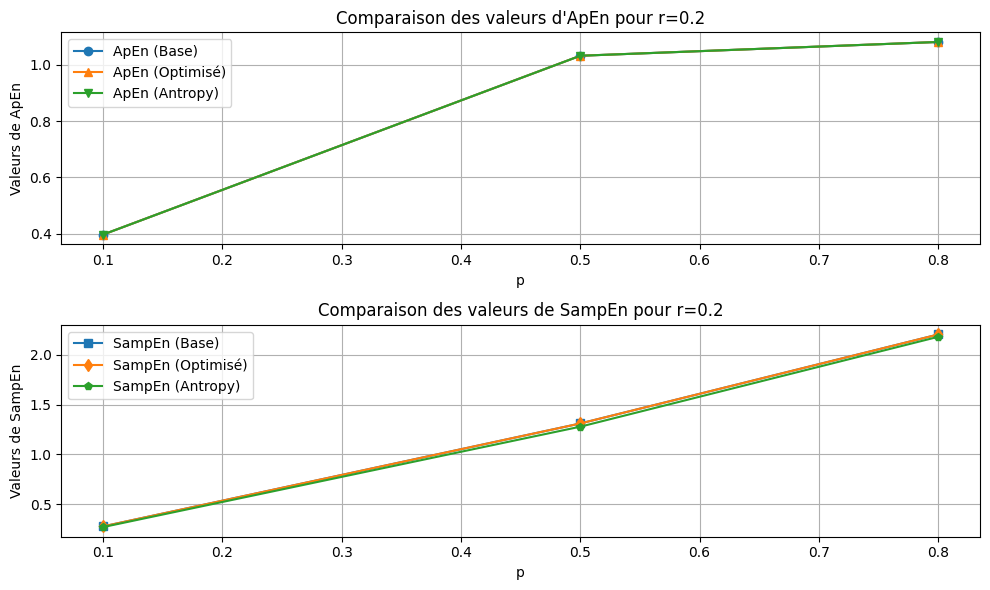

In [18]:
# Paramètres
P_ = [0.1, 0.5, 0.8]  # Valeurs de p
r_fixed = 0.2         # Tolérance fixée

# Création des listes pour stocker les valeurs finales
apen_base = []
apen_opt = []
apen_antropy = []
sampen_base = []
sampen_opt = []
sampen_antropy = []

# Récupération des valeurs pour chaque p
for p_value in P_:
    indices_p = [i for i, p in enumerate(resultat['p']) if p == p_value and resultat['r'][i] == r_fixed]
    
    # Stockage des valeurs pour chaque version
    apen_base.append(resultat['ApEn'][indices_p[0]])
    apen_opt.append(resultat['ApEn_opt'][indices_p[0]])
    apen_antropy.append(resultat['ApEn_antropy'][indices_p[0]])
    
    sampen_base.append(resultat['SampEn'][indices_p[0]])
    sampen_opt.append(resultat['SampEn_opt'][indices_p[0]])
    sampen_antropy.append(resultat['SampEn_antropy'][indices_p[0]])

# Création de la figure
plt.figure(figsize=(10, 6))

# 1. Comparaison des valeurs pour ApEn
plt.subplot(2, 1, 1)
plt.plot(P_, apen_base, label='ApEn (Base)', marker='o')
plt.plot(P_, apen_opt, label='ApEn (Optimisé)', marker='^')
plt.plot(P_, apen_antropy, label='ApEn (Antropy)', marker='v')
plt.xlabel("p")
plt.ylabel("Valeurs de ApEn")
plt.title(f"Comparaison des valeurs d'ApEn pour r={r_fixed}")
plt.legend()
plt.grid()

# 2. Comparaison des valeurs pour SampEn
plt.subplot(2, 1, 2)
plt.plot(P_, sampen_base, label='SampEn (Base)', marker='s')
plt.plot(P_, sampen_opt, label='SampEn (Optimisé)', marker='d')
plt.plot(P_, sampen_antropy, label='SampEn (Antropy)', marker='p')
plt.xlabel("p")
plt.ylabel("Valeurs de SampEn")
plt.title(f"Comparaison des valeurs de SampEn pour r={r_fixed}")
plt.legend()
plt.grid()

# Ajustement et affichage
plt.tight_layout()
plt.show()


Les graphes sont confondues, l'output de nos implémentations sont donc satisfaisantes. 

#### Comparaisons temporelles entre les implémentations

In [19]:
N_ = [250, 500, 1000, 10000]  # Longueur de la série
P__ = [0.1] # Proportion de bruit
mix_n = []
for n in N_ : 
    mix_n.append(generate_mix_series(N, p, amplitude=1.0, frequency=1.0))


In [20]:

temps_execution = {'ApEn':[],'SampEn':[],'ApEn_opt':[], 'ApEn_antropy':[],'SampEn_opt':[], 'SampEn_antropy':[],'r':[], 'N':[]}
c = 0
for i in range(len(mix_n)) : 
    signal = mix_n[i]
    r = 0.2
    start_time = t.perf_counter()
    c = apen(signal, m, r)
    end_time = t.perf_counter()
    temps_execution['ApEn'].append(-start_time + end_time)
    start_time = t.perf_counter()
    c = approx_entropy(signal, m, r)
    end_time = t.perf_counter()
    temps_execution['ApEn_opt'].append(-start_time + end_time)
    start_time = t.perf_counter()
    c = approx_entropy_antropy(signal, m, r)
    end_time = t.perf_counter()
    temps_execution['ApEn_antropy'].append(-start_time + end_time)
    start_time = t.perf_counter()
    c = sampen(signal, m, r)
    end_time = t.perf_counter()
    temps_execution['SampEn'].append(-start_time + end_time)
    start_time = t.perf_counter()
    c = sample_entropy(signal, m, r)
    end_time = t.perf_counter()
    temps_execution['SampEn_opt'].append(-start_time + end_time)
    start_time = t.perf_counter()
    c = sample_entropy_antropy(signal, m, r)
    end_time = t.perf_counter()
    temps_execution['SampEn_antropy'].append(-start_time + end_time)
    temps_execution['N'].append(N_[i])
    temps_execution['r'].append(r)

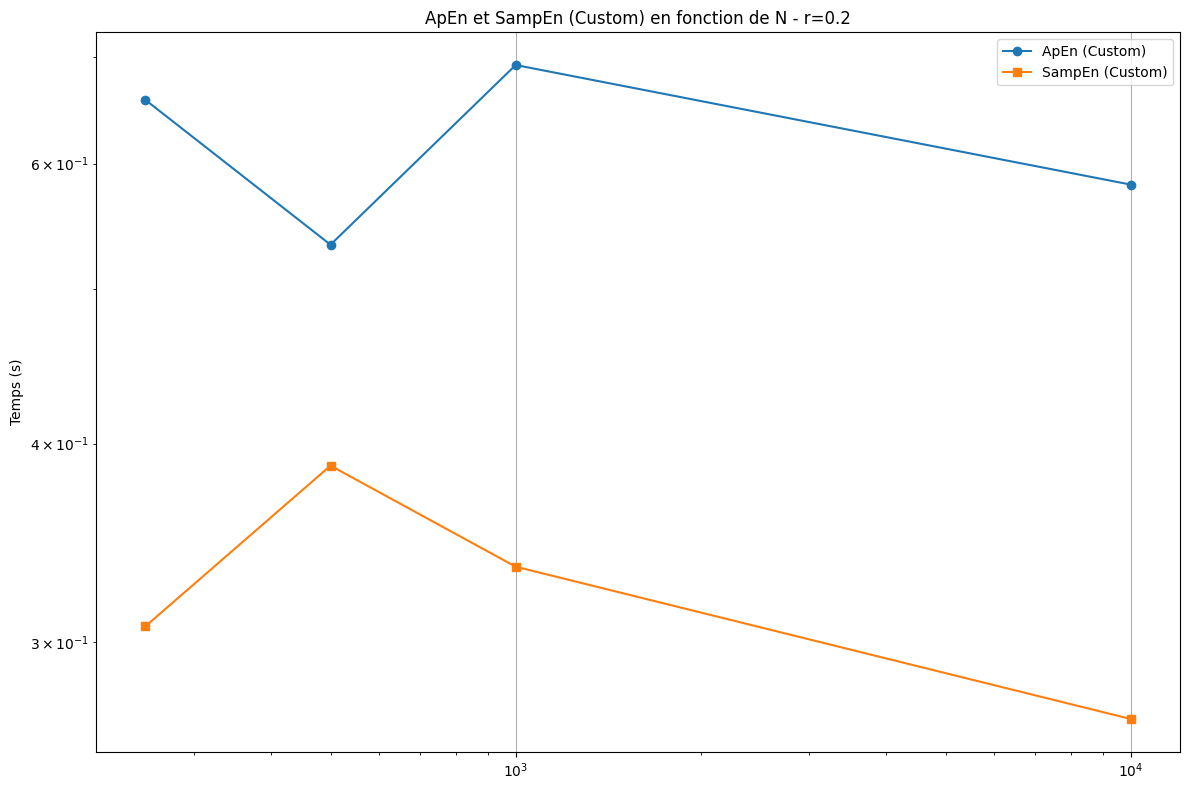

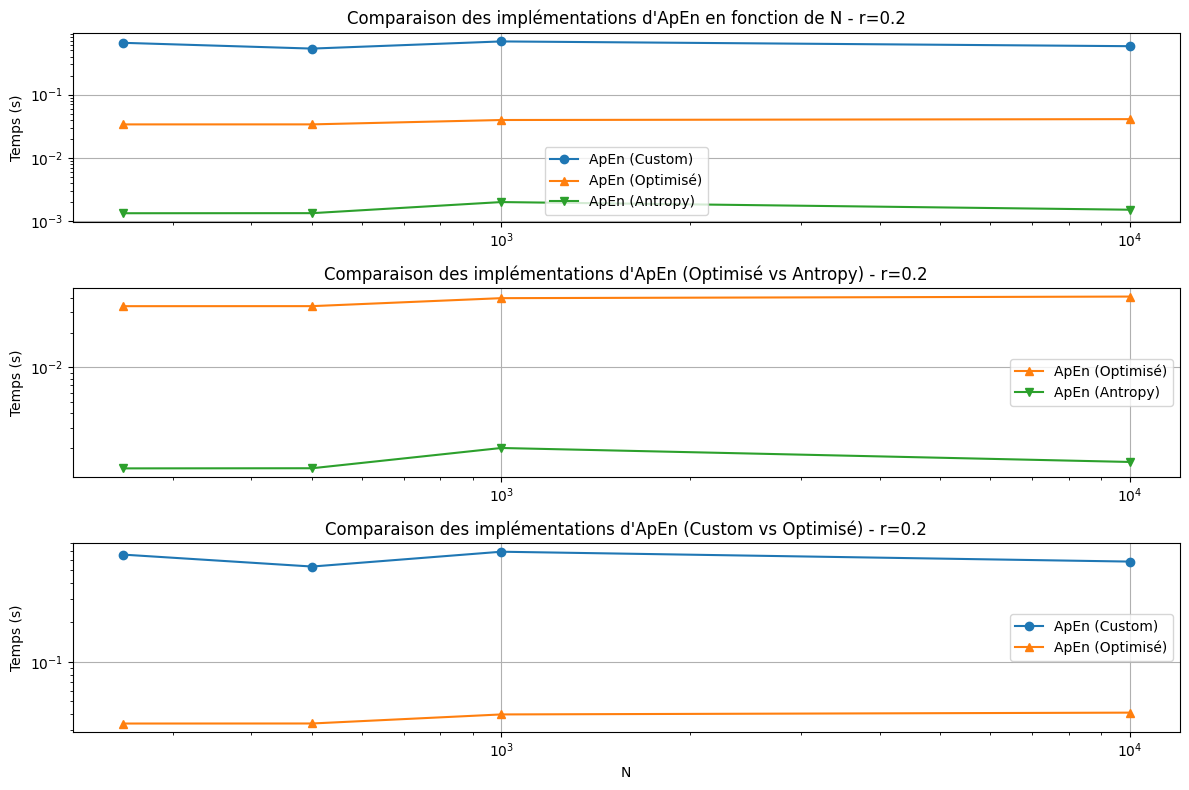

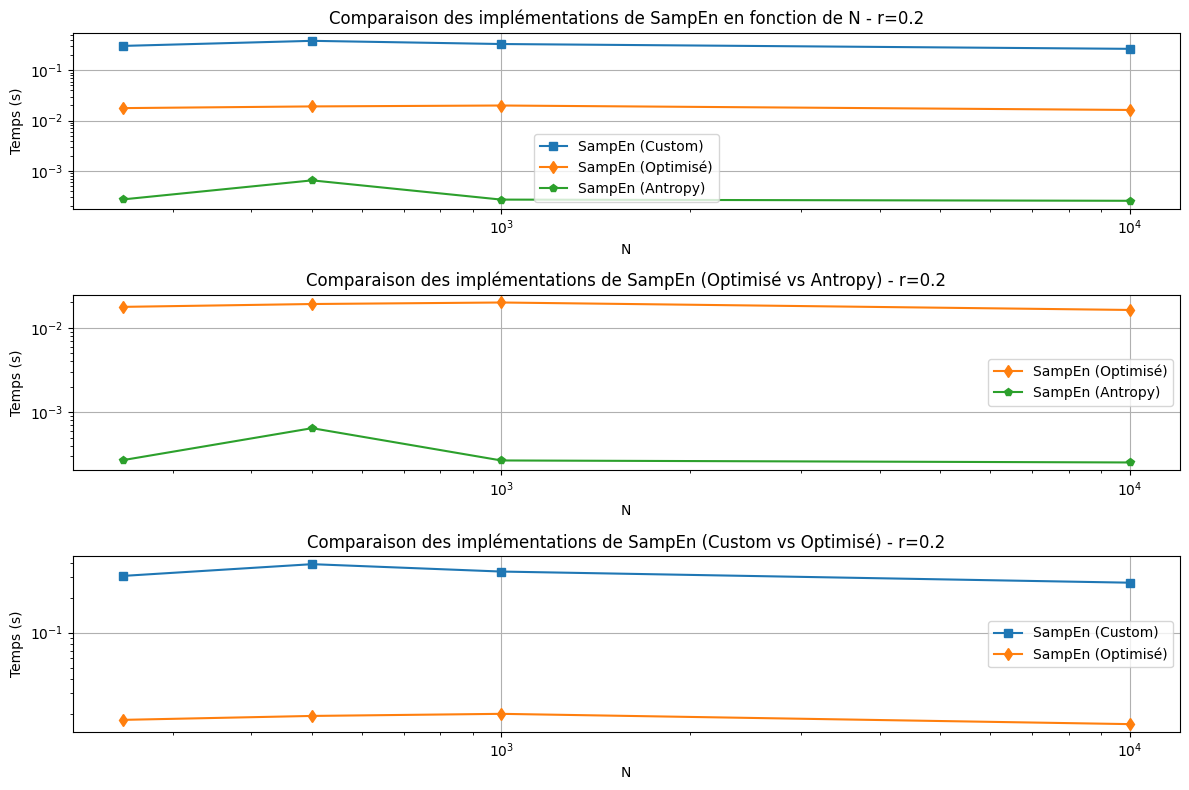

In [21]:

# Paramètres
P_ = N_  # Valeurs de p
r_fixed = 0.2         # Tolérance fixée

# Création des listes pour stocker les temps d'exécution
apen_times = []
sampen_times = []
apen_opt_times = []
apen_antropy_times = []
sampen_opt_times = []
sampen_antropy_times = []

# Récupération des temps pour chaque p à r fixé


# Création de la figure
plt.figure(figsize=(12, 8))

# 1. Temps d'exécution pour ApEn et SampEn (Custom)
plt.subplot(1, 1, 1)
plt.plot(P_, temps_execution['ApEn'], label='ApEn (Custom)', marker='o')
plt.plot(P_, temps_execution['SampEn'], label='SampEn (Custom)', marker='s')
plt.ylabel("Temps (s)")
plt.xscale('log')
plt.yscale('log')
plt.title(f"ApEn et SampEn (Custom) en fonction de N - r={r_fixed}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Fixation des couleurs pour chaque courbe
colors = {
    'ApEn (Custom)': 'tab:blue',
    'ApEn (Optimisé)': 'tab:orange',
    'ApEn (Antropy)': 'tab:green'
}

# Création de la figure
plt.figure(figsize=(12, 8))

# 1. Comparaison des implémentations d'ApEn (toutes courbes)
plt.subplot(3, 1, 1)
plt.plot(P_, temps_execution['ApEn'], label='ApEn (Custom)', marker='o', color=colors['ApEn (Custom)'])
plt.plot(P_, temps_execution['ApEn_opt'], label='ApEn (Optimisé)', marker='^', color=colors['ApEn (Optimisé)'])
plt.plot(P_, temps_execution['ApEn_antropy'], label='ApEn (Antropy)', marker='v', color=colors['ApEn (Antropy)'])
plt.ylabel("Temps (s)")
plt.xscale('log')
plt.yscale('log')
plt.title(f"Comparaison des implémentations d'ApEn en fonction de N - r={r_fixed}")
plt.legend()
plt.grid()

# 2. Comparaison d'ApEn Optimisé et Antropy seulement
plt.subplot(3, 1, 2)
plt.plot(P_, temps_execution['ApEn_opt'], label='ApEn (Optimisé)', marker='^', color=colors['ApEn (Optimisé)'])
plt.plot(P_, temps_execution['ApEn_antropy'], label='ApEn (Antropy)', marker='v', color=colors['ApEn (Antropy)'])
plt.ylabel("Temps (s)")
plt.xscale('log')
plt.yscale('log')
plt.title(f"Comparaison des implémentations d'ApEn (Optimisé vs Antropy) - r={r_fixed}")
plt.legend()
plt.grid()

# 3. Comparaison d'ApEn Custom et Optimisé seulement
plt.subplot(3, 1, 3)
plt.plot(P_, temps_execution['ApEn'], label='ApEn (Custom)', marker='o', color=colors['ApEn (Custom)'])
plt.plot(P_, temps_execution['ApEn_opt'], label='ApEn (Optimisé)', marker='^', color=colors['ApEn (Optimisé)'])
plt.ylabel("Temps (s)")
plt.xlabel("N")
plt.xscale('log')
plt.yscale('log')
plt.title(f"Comparaison des implémentations d'ApEn (Custom vs Optimisé) - r={r_fixed}")
plt.legend()
plt.grid()

# Ajustement et affichage
plt.tight_layout()
plt.show()

# Fixation des couleurs pour chaque courbe
colors = {
    'SampEn (Custom)': 'tab:blue',
    'SampEn (Optimisé)': 'tab:orange',
    'SampEn (Antropy)': 'tab:green'
}

# Création de la figure
plt.figure(figsize=(12, 8))

# 1. Comparaison des implémentations de SampEn (toutes courbes)
plt.subplot(3, 1, 1)
plt.plot(P_, temps_execution['SampEn'], label='SampEn (Custom)', marker='s', color=colors['SampEn (Custom)'])
plt.plot(P_, temps_execution['SampEn_opt'], label='SampEn (Optimisé)', marker='d', color=colors['SampEn (Optimisé)'])
plt.plot(P_, temps_execution['SampEn_antropy'], label='SampEn (Antropy)', marker='p', color=colors['SampEn (Antropy)'])
plt.xlabel("N")
plt.yscale('log')
plt.xscale('log')
plt.ylabel("Temps (s)")
plt.title(f"Comparaison des implémentations de SampEn en fonction de N - r={r_fixed}")
plt.legend()
plt.grid()

# 2. Comparaison de SampEn (Optimisé vs Antropy)
plt.subplot(3, 1, 2)
plt.plot(P_, temps_execution['SampEn_opt'], label='SampEn (Optimisé)', marker='d', color=colors['SampEn (Optimisé)'])
plt.plot(P_, temps_execution['SampEn_antropy'], label='SampEn (Antropy)', marker='p', color=colors['SampEn (Antropy)'])
plt.xlabel("N")
plt.xscale('log')
plt.ylabel("Temps (s)")
plt.yscale('log')
plt.title(f"Comparaison des implémentations de SampEn (Optimisé vs Antropy) - r={r_fixed}")
plt.legend()
plt.grid()

# 3. Comparaison de SampEn (Custom vs Optimisé)
plt.subplot(3, 1, 3)
plt.plot(P_, temps_execution['SampEn'], label='SampEn (Custom)', marker='s', color=colors['SampEn (Custom)'])
plt.plot(P_, temps_execution['SampEn_opt'], label='SampEn (Optimisé)', marker='d', color=colors['SampEn (Optimisé)'])
plt.xlabel("N")
plt.xscale('log')
plt.ylabel("Temps (s)")
plt.yscale('log')
plt.title(f"Comparaison des implémentations de SampEn (Custom vs Optimisé) - r={r_fixed}")
plt.legend()
plt.grid()

# Ajustement et affichage
plt.tight_layout()
plt.show()




#### Versions cross 

In [22]:
# Initialisation du dictionnaire pour les résultats
resultat_cross = {
    'CrossApEn_EH': [],'CrossApEn_max_opt': [],'CrossApEn_0_opt': [], 'CrossSampEn_EH': [], 'CrossApEn_opt': [], 'CrossSampEn_opt': [],
    'r': [], 'p': [], 'q': []
}

# Paramètres
r = 0.2  # Tolérance fixée
m = 2    # Taille des motifs  
P = [0,0.1,0.5]
Q = [0,0.1,0.5]
mix_p = [generate_mix_series(N, p, 1, 1) for p in P]  # Génération de séries de taille N
mix_q = [generate_mix_series(N, q, 1, 1) for q in Q]
# Boucle sur les séries mix_p et mix_q pour les versions Cross
for i in range(len(mix_p)):
    signal_p = mix_p[i]
    for j in range(len(mix_q)):
        signal_q = mix_q[j]
        r = 0.2  # Fixation de la tolérance

        # Cross-ApEn (Base)
        cross_apen_value = cross_apen_opt(signal_p, signal_q, m, r)
        resultat_cross['CrossApEn_opt'].append(cross_apen_value)
        # Cross-ApEn (Base)
        cross_apen_value = cross_apen_biais_0_opt(signal_p, signal_q, m, r)
        resultat_cross['CrossApEn_0_opt'].append(cross_apen_value)
        # Cross-ApEn (Base)
        cross_apen_value = cross_apen_biais_max_opt(signal_p, signal_q, m, r)
        resultat_cross['CrossApEn_max_opt'].append(cross_apen_value)
        # Cross-ApEn (EH)
        cross_apen_antropy_value = cross_approx_entropy_EH(signal_p, signal_q, m, r)
        resultat_cross['CrossApEn_EH'].append(cross_apen_antropy_value)
        # Cross-SampEn (Base)
        cross_sampen_value = cross_sampen_opt(signal_p, signal_q, m, r)
        resultat_cross['CrossSampEn_opt'].append(cross_sampen_value)

        # Cross-SampEn (EH)
        cross_sampen_antropy_value = cross_sample_entropy_EH(signal_p, signal_q, m, r)
        resultat_cross['CrossSampEn_EH'].append(cross_sampen_antropy_value)
        # Enregistrement des paramètres p, q et r
        resultat_cross['p'].append(P[i])
        resultat_cross['q'].append(Q[j])
        resultat_cross['r'].append(r)


(array([1.99051046, 0.06196074, 0.0666495 ]), array([ 0.        , -1.99051046, -2.0524712 , -2.11912071]))
(array([ 2.0138967 , -0.17739412, -0.05474269]), array([ 0.        , -2.0138967 , -1.83650258, -1.78175989]))
(array([ 2.10324484, -1.09438331, -0.43139127]), array([ 0.        , -2.10324484, -0.94997068, -0.51857941]))
(array([2.01342145, 0.2387876 , 0.1685877 ]), array([ 0.        , -2.01342145, -2.25220905, -2.42079675]))
(array([2.02841144, 0.25612276, 0.04411839]), array([ 0.        , -2.02841144, -2.2845342 , -2.32865259]))
(array([ 2.11724208,  0.2094245 , -1.10783592]), array([ 0.        , -2.11724208, -2.32666658, -1.21883066]))
(array([2.13078537, 1.17593195, 0.77598408]), array([ 0.        , -2.13078537, -3.30671732, -4.08270141]))
(array([2.1249889 , 1.334426  , 0.48396068]), array([ 0.        , -2.1249889 , -3.4594149 , -3.94337558]))
(array([ 2.14194301,  1.83429238, -1.48614405]), array([ 0.        , -2.14194301, -3.97623539, -2.49009134]))


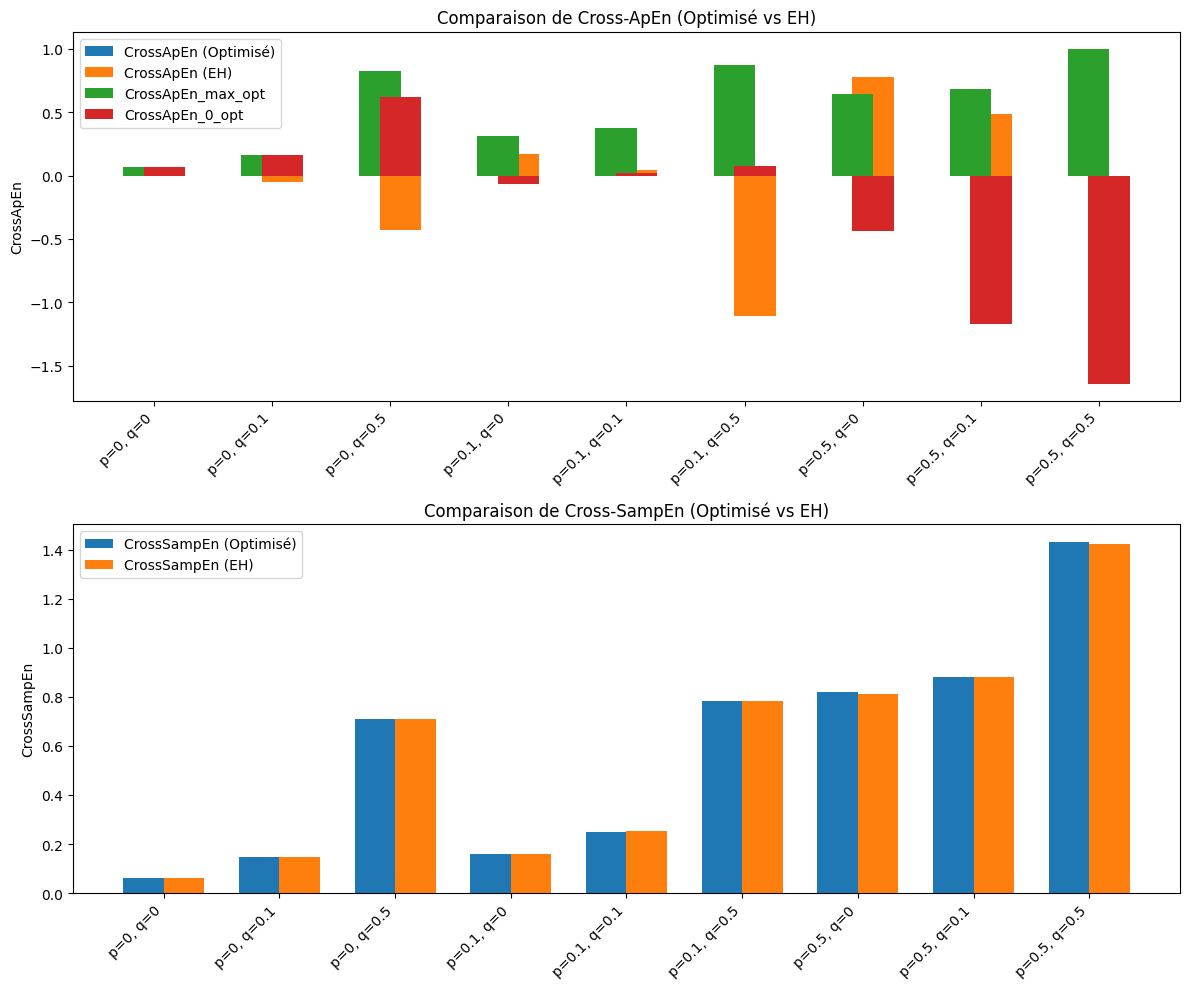

In [23]:
# Extraction des données du dictionnaire resultat_cross
p_values = resultat_cross['p']
q_values = resultat_cross['q']

cross_apen_opt_ = resultat_cross['CrossApEn_opt']
cross_apen_biais_max_opt = resultat_cross['CrossApEn_max_opt']
cross_apen_biais_0_opt = resultat_cross['CrossApEn_0_opt']
cross_apen_eh = resultat_cross['CrossApEn_EH']
cross_sampen_opt_ = resultat_cross['CrossSampEn_opt']
cross_sampen_eh = resultat_cross['CrossSampEn_EH']

# Convertir p et q en chaînes pour affichage clair
pq_labels = [f"p={p}, q={q}" for p, q in zip(p_values, q_values)]

# Création des graphiques
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plot CrossApEn Comparaison
x = np.arange(len(pq_labels))  # Axe X pour les étiquettes (combinaisons p, q)
width = 0.35  # Largeur des barres

axs[0].bar(x - width/4, cross_apen_opt_, width, label='CrossApEn (Optimisé)')
axs[0].bar(x + width/4, cross_apen_eh, width, label='CrossApEn (EH)')
axs[0].bar(x - width/4, cross_apen_biais_max_opt, width, label='CrossApEn_max_opt')
axs[0].bar(x + width/4, cross_apen_biais_0_opt , width, label='CrossApEn_0_opt')

axs[0].set_title('Comparaison de Cross-ApEn (Optimisé vs EH)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(pq_labels, rotation=45, ha='right')
axs[0].set_ylabel('CrossApEn')
axs[0].legend()

# Plot CrossSampEn Comparaison
axs[1].bar(x - width/2, cross_sampen_opt_, width, label='CrossSampEn (Optimisé)')
axs[1].bar(x + width/2, cross_sampen_eh, width, label='CrossSampEn (EH)')

axs[1].set_title('Comparaison de Cross-SampEn (Optimisé vs EH)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(pq_labels, rotation=45, ha='right')
axs[1].set_ylabel('CrossSampEn')
axs[1].legend()

# Ajustement et affichage
plt.tight_layout()
plt.show()

In [24]:
import time as t

# Initialisation du dictionnaire pour les temps d'exécution
temps_execution = {
    'CrossApEn': [], 'CrossApEn_opt': [], 'CrossApEn_EH' : [],
    'CrossSampEn': [], 'CrossSampEn_opt': [], 
    'CrossSampEn_EH' : [],
    'r': [], 'N': []
}

# Paramètres
r = 0.2  # Tolérance fixée
m = 2    # Taille des motifs
N_ = [50, 100, 250, 500, 1000]  # Tailles de signaux
mix_n = [generate_mix_series(N, 0.5, 1, 1) for N in N_]  # Génération de séries de taille N
mix_q = [generate_mix_series(N, 0.7, 1, 1) for N in N_]  # Deuxième série pour les versions Cross

# Boucle sur les séries temporelles et tailles de signal
for i in range(len(mix_n)):
    signal_u = mix_n[i]
    signal_v = mix_q[i]

    # Cross-ApEn (Base)
    start_time = t.perf_counter()
    c = cross_apen(signal_u, signal_v, m, r)
    end_time = t.perf_counter()
    temps_execution['CrossApEn'].append(-start_time + end_time)

    # Cross-ApEn (Optimisé)
    start_time = t.perf_counter()
    c = cross_apen_opt(signal_u, signal_v, m, r)
    end_time = t.perf_counter()
    temps_execution['CrossApEn_opt'].append(-start_time + end_time)

    # Cross-ApEn (Package EH)
    start_time = t.perf_counter()
    c = cross_approx_entropy_EH(signal_u, signal_v, m, r)
    end_time = t.perf_counter()
    temps_execution['CrossApEn_EH'].append(-start_time + end_time)

    # Cross-SampEn (Base)
    start_time = t.perf_counter()
    c = cross_sampen(signal_u, signal_v, m, r)
    end_time = t.perf_counter()
    temps_execution['CrossSampEn'].append(-start_time + end_time)

    # Cross-SampEn (Optimisé)
    start_time = t.perf_counter()
    c = cross_sampen_opt(signal_u, signal_v, m, r)
    end_time = t.perf_counter()
    temps_execution['CrossSampEn_opt'].append(-start_time + end_time)

    # Cross-SampEn (Package EH)
    start_time = t.perf_counter()
    c = cross_sample_entropy_EH(signal_u, signal_v, m, r)
    end_time = t.perf_counter()
    temps_execution['CrossSampEn_EH'].append(-start_time + end_time)

    # Enregistrement des paramètres
    temps_execution['N'].append(N_[i])
    temps_execution['r'].append(r)



(array([ 2.46463678, -0.71099703, -1.51168969]), array([ 0.        , -2.46463678, -1.75363975, -0.24195006]))
(array([ 2.20227519,  0.93057558, -2.365791  ]), array([ 0.        , -2.20227519, -3.13285078, -0.76705978]))
(array([ 2.17893251,  1.9294378 , -2.3217192 ]), array([ 0.        , -2.17893251, -4.08222311, -1.76050392]))
(array([ 2.12064784,  2.16069289, -1.00021344]), array([ 0.        , -2.12064784, -4.28134073, -3.28112729]))
(array([2.16453701, 2.22196849, 0.03934574]), array([ 0.        , -2.16453701, -4.3865055 , -4.42585123]))


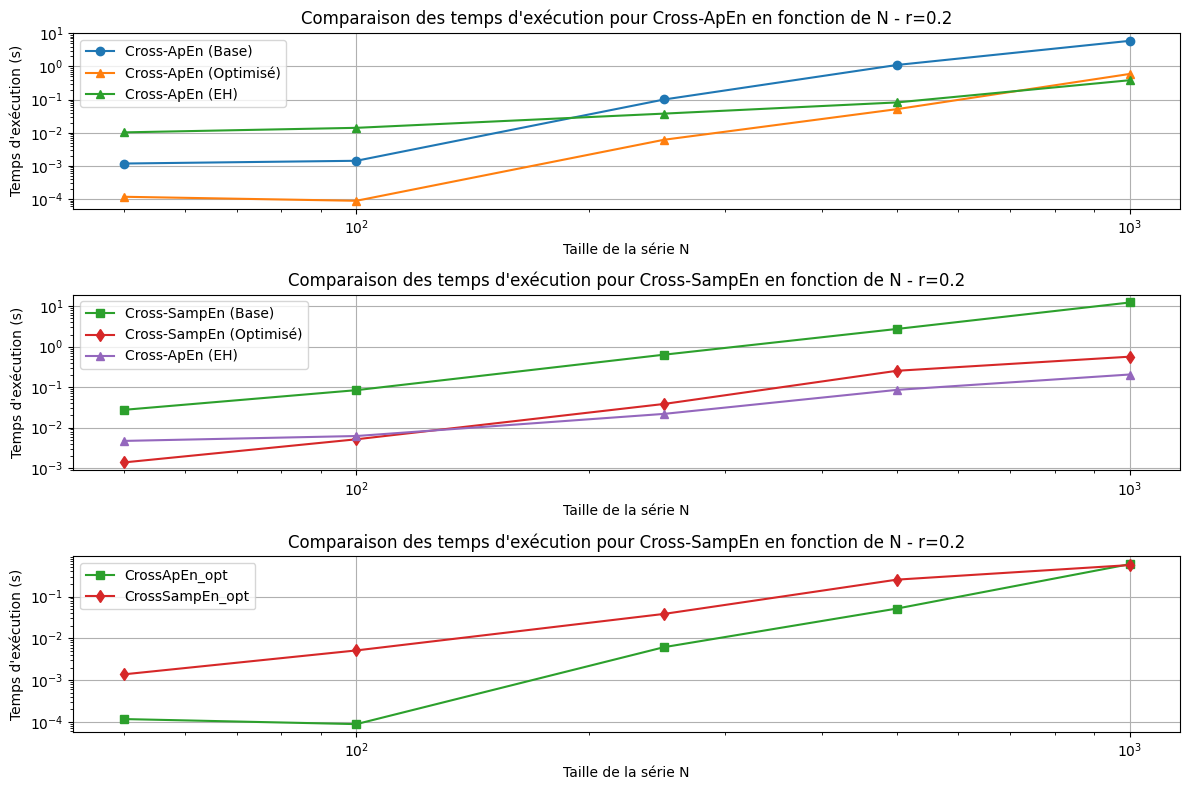

In [25]:

# Paramètres
P_ = N_  # Taille des séries temporelles
r_fixed = 0.2  # Tolérance fixée

# Création des couleurs pour les courbes
colors_cross = {
    'Cross-ApEn (Base)': 'tab:blue',
    'Cross-ApEn (Optimisé)': 'tab:orange',
    'Cross-ApEn (EH)': 'tab:green',
    'Cross-SampEn (EH)': 'tab:purple',
    'Cross-SampEn (Base)': 'tab:green',
    'Cross-SampEn (Optimisé)': 'tab:red'
}

# Création de la figure
plt.figure(figsize=(12, 8))

# 1. Comparaison des temps pour Cross-ApEn
plt.subplot(3, 1, 1)
plt.plot(P_, temps_execution['CrossApEn'], label='Cross-ApEn (Base)', marker='o', color=colors_cross['Cross-ApEn (Base)'])
plt.plot(P_, temps_execution['CrossApEn_opt'], label='Cross-ApEn (Optimisé)', marker='^', color=colors_cross['Cross-ApEn (Optimisé)'])
plt.plot(P_, temps_execution['CrossApEn_EH'], label='Cross-ApEn (EH)', marker='^', color=colors_cross['Cross-ApEn (EH)'])
plt.xlabel("Taille de la série N")
plt.ylabel("Temps d'exécution (s)")
plt.xscale('log')
plt.yscale('log')
plt.title(f"Comparaison des temps d'exécution pour Cross-ApEn en fonction de N - r={r_fixed}")
plt.legend()
plt.grid()

# 2. Comparaison des temps pour Cross-SampEn
plt.subplot(3, 1, 2)
plt.plot(P_, temps_execution['CrossSampEn'], label='Cross-SampEn (Base)', marker='s', color=colors_cross['Cross-SampEn (Base)'])
plt.plot(P_, temps_execution['CrossSampEn_opt'], label='Cross-SampEn (Optimisé)', marker='d', color=colors_cross['Cross-SampEn (Optimisé)'])
plt.plot(P_, temps_execution['CrossSampEn_EH'], label='Cross-ApEn (EH)', marker='^', color=colors_cross['Cross-SampEn (EH)'])
plt.xlabel("Taille de la série N")
plt.ylabel("Temps d'exécution (s)")
plt.xscale('log')
plt.yscale('log')
plt.title(f"Comparaison des temps d'exécution pour Cross-SampEn en fonction de N - r={r_fixed}")
plt.legend()
plt.grid()

# 2. Comparaison des temps pour Cross-SampEn
plt.subplot(3, 1, 3)
plt.plot(P_, temps_execution['CrossApEn_opt'], label='CrossApEn_opt', marker='s', color=colors_cross['Cross-SampEn (Base)'])
plt.plot(P_, temps_execution['CrossSampEn_opt'], label='CrossSampEn_opt', marker='d', color=colors_cross['Cross-SampEn (Optimisé)'])
plt.xlabel("Taille de la série N")
plt.ylabel("Temps d'exécution (s)")
plt.xscale('log')
plt.yscale('log')
plt.title(f"Comparaison des temps d'exécution pour Cross-SampEn en fonction de N - r={r_fixed}")
plt.legend()
plt.grid()

# Ajustement et affichage
plt.tight_layout()
plt.show()


## Résultats expérimentaux

### Données simulées

In [ ]:
N = 250 
P = [0.1*k for k in range(0,11)]
Q = [0.5,0.7]

m = 2
R = np.logspace(np.log10(0.01), np.log10(1), 10) #échelle log pour r

mix_p = [generate_mix_series(N,p,1,1) for p in P]
mix_q = [generate_mix_series(N,q,1,1) for q in Q]

In [ ]:
result = {'ApEn':[],'SampEn':[],'signal_p':[], 'r':[]}
result_cross={'CrossApEn':[],'CrossSampEn':[], 'signal_p':[], 'signal_q':[], 'r':[]}
for i in range(len(mix_p)) : 
    signal = mix_p[i]
    for r in R : 
        result['ApEn'].append(approx_entropy(signal, m, r))
        result['SampEn'].append(sample_entropy(signal, m, r))
        result['signal_p'].append(P[i])
        result['r'].append(r)

    for j in range(len(mix_q)) :
        signal_ = mix_q[j] 
        for r in R : 
            result_cross['CrossApEn'].append(cross_apen_opt(signal, signal_, m, r))
            result_cross['CrossSampEn'].append(cross_sampen_opt(signal, signal_, m, r))
            result_cross['signal_p'].append(P[i])
            result_cross['signal_q'].append(Q[j])
            result_cross['r'].append(r)

    


KeyboardInterrupt: 

In [ ]:
result = pd.DataFrame(result)
result_cross = pd.DataFrame(result_cross)

In [ ]:
index_bis = [(q,r,p) for q in Q for r in R  for p in P ]

In [ ]:
for i in range(len(R)): 
    # Tracé les résultats selon la tolérance
    plt.plot(P, result['ApEn'][result['r'] == R[i]], label='ApEn', marker='o', linestyle='--', markersize=5)
    plt.plot(P, result['SampEn'][result['r']  == R[i]], label='SampEn', marker='s', linestyle='--', markersize=5)
    # Configuration du graphique
    # Échelle logarithmique pour R
    plt.xlabel('P', fontsize=12)
    plt.ylabel('Valeurs des indicateurs', fontsize=12)
    plt.title(f'Indicateurs en fonction de la proportion de bruit avec r={R[i]}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Affichage
    plt.show()

In [ ]:
for i in range(len(mix_p)): 
    # Tracé les résultats selon la tolérance
    plt.plot(R, result['ApEn'][result['signal_p'] == P[i]], label='ApEn', marker='o', linestyle='--', markersize=5)
    plt.plot(R, result['SampEn'][result['signal_p']  == P[i]], label='SampEn', marker='s', linestyle='--', markersize=5)
    # Configuration du graphique
    # Échelle logarithmique pour R
    plt.xlabel('r', fontsize=12)
    plt.ylabel('Valeurs des indicateurs', fontsize=12)
    plt.title(f'Indicateurs en fonction de r sur MIX({P[i]})', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Affichage
    plt.show()

In [ ]:
M = [2,4,5,7,10]
result_m = {'ApEn':[],'SampEn':[], 'm':[]}
result_cross_m={'CrossApEn':[],'CrossSampEn':[], 'm':[]}
temps_execution_m = {'ApEn':[],'SampEn':[],'CrossApEn':[],'CrossSampEn':[]} 
for m in M : 
    signal = mix_p[1]
    r = R[1] 
    result_m['ApEn'].append(apen(signal, m, r))
    result_m['SampEn'].append(sampen(signal, m, r))
    result_m['m'].append(m)
    signal_ = mix_q[1] 
    result_cross_m['CrossApEn'].append(cross_apen(signal, signal_, m, r))
    result_cross_m['CrossSampEn'].append(cross_sampen(signal, signal_, m, r))
    result_cross_m['m'].append(m)


In [ ]:

# Tracé les résultats selon la tolérance
plt.plot(M, result_m['ApEn'], label='ApEn', marker='o', linestyle='--', markersize=5)
plt.plot(M, result_m['SampEn'], label='SampEn', marker='s', linestyle='--', markersize=5)
# Configuration du graphique
# Échelle logarithmique pour R
plt.xlabel('m', fontsize=12)
plt.ylabel('Valeurs des indicateurs', fontsize=12)
plt.title(f'Indicateurs en fonction de m sur MIX({P[1]})', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Affichage
plt.show()

### Données réelles

In [ ]:
def plot_ap_vs_samp(signal, m=3):
    r_values = np.linspace(0.01, 1, 50)
    apen_values = [approx_entropy(signal, m, r) for r in r_values]
    sampen_values = [sample_entropy(signal, m, r) for r in r_values]
    plt.figure(figsize=(10, 6))
    plt.plot(r_values, apen_values, label='Approximate Entropy (ApEn)')
    plt.plot(r_values, sampen_values, label='Sample Entropy (SampEn)')
    plt.xscale('log')
    plt.xlabel('r')
    plt.ylabel('Entropy')
    plt.title('Approximate Entropy and Sample Entropy vs. r')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def comparer_ap(signaux, m=3):
    """
    Compare l'Approximate Entropy (ApEn) pour plusieurs signaux sur différentes valeurs de r.
    
    Args:
        signaux (list): Liste de séries temporelles (array-like).
        m (int): Taille des motifs.
    """
    plt.figure(figsize=(10, 6))
    r_values = np.linspace(0.01, 1, 50) 
    
    for i, signal in enumerate(signaux):
        apen_values = [approx_entropy(signal, m, r) for r in r_values]  
        plt.plot(r_values, apen_values, label=f'ApEn signal {i + 1}') 

    # Configurations du graphique
    plt.xscale('log')  # Échelle logarithmique pour l'axe x
    plt.xlabel('r')
    plt.ylabel('Approximate Entropy')
    plt.title('Approximate Entropy Comparison')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def comparer_samp(signaux, m=3):
    """
    Compare l'Approximate Entropy (ApEn) pour plusieurs signaux sur différentes valeurs de r.
    
    Args:
        signaux (list): Liste de séries temporelles (array-like).
        m (int): Taille des motifs.
    """
    plt.figure(figsize=(10, 6))
    r_values = np.linspace(0.01, 1, 50) 
    
    for i, signal in enumerate(signaux):
        apen_values = [sample_entropy(signal, m, r) for r in r_values] 
        plt.plot(r_values, apen_values, label=f'SampEn signal {i + 1}') 

    # Configurations du graphique
    plt.xscale('log')  # Échelle logarithmique pour l'axe x
    plt.xlabel('r')
    plt.ylabel('Sample Entropy')
    plt.title('Sample Entropy Comparison')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

In [ ]:
# Chemin données
data_set = ['ECGFiveDays', 'ECG5000', 'ECG200'] #ECGFiveDays, ECG5000, ECG200
TRAIN_TEST = 'TRAIN'
signaux = []

for data in data_set:
    file_path = f"{data}/{data}_{TRAIN_TEST}.arff"
    with open(file_path, 'r') as f:
        data = arff.load(f)

    data_values = np.array(data['data'])

    signals = data_values[:, :-1] 
    labels = data_values[:, -1]    

    signal_index = np.random.randint(low=0, high=len(signals))
    print(signal_index) 
    signal = signals[signal_index, :]
    signal.shape
    signal = signal.astype(np.float64)
    normalized_signal = normalize_signal(signal)
    signaux.append(normalized_signal)
    plot_ap_vs_samp(normalized_signal, m=3)

17


KeyboardInterrupt: 

In [ ]:
comparer_ap(signaux, m=3)

NameError: name 'comparer_ap' is not defined

In [ ]:
comparer_samp(signaux, m=3)